In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from astromodal.config import load_config
from tqdm import tqdm
import polars as pl
import random
from pathlib import Path

In [3]:
config = load_config("config.yaml")

print(config['datacubes_paths'])
config

/home/astrodados4/downloads/hypercube/datacube_*.parquet


{'datacubes_paths': '/home/astrodados4/downloads/hypercube/datacube_*.parquet',
 'models_folder': '/home/schwarz/projetoFM/models',
 'hdd_folder': '/home/astrodados4/downloads/projetin'}

In [4]:
hdd_folder = config['hdd_folder']

hddfolder = Path(config["hdd_folder"]) / "image_latents" 

In [5]:
all_latents = None
for key, file in enumerate(hddfolder.glob("*.parquet")):
    latents = pl.read_parquet(file, use_pyarrow=True)
    
    if all_latents is None:
        all_latents = latents
    else:
        all_latents = pl.concat([all_latents, latents])
        
    if key == 20:
        break

In [6]:
from astromodal.tokenizers.resvq import ResidualVQ, SpatialRVQ

In [7]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm 
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"

latents_tensor = torch.tensor(all_latents['latent'].to_numpy(), device=device)

D = latents_tensor.shape[1]
#latents = F.normalize(latents_tensor, dim=1)
latents = latents_tensor

In [8]:
print("mean ||z||:", latents.norm(dim=1).mean().item())
print("std  ||z||:", latents.norm(dim=1).std().item())
print("mean z:", latents.mean().item(), "std z:", latents.std().item())

mean ||z||: 259.8090515136719
std  ||z||: 2.1411292552948
mean z: -5.196170806884766 std z: 5.621226787567139


In [11]:
@torch.no_grad()
def recon_metrics(z, z_hat):
    # z, z_hat: [B, D] (flattened)
    mean_sq_L2 = ((z - z_hat) ** 2).sum(dim=1).mean()
    per_dim_MSE = ((z - z_hat) ** 2).mean()
    return mean_sq_L2.item(), per_dim_MSE.item()

# z_map: [B, C=4, H=24, W=24]
srvq = SpatialRVQ(channels=2, num_stages=2, codebook_size=2048, decay=0.99).to(device)
srvq.train()

z_map = latents.view(-1, 2, 24, 24)

loader = DataLoader(TensorDataset(z_map), batch_size=64, shuffle=True, drop_last=True)

for epoch in range(10):
    n_sum = 0
    mse_sum = 0.0
    l2_sum = 0.0

    for (z_map,) in loader:  # [B,2,24,24]
        z_map = z_map.to(device)
        out = srvq(z_map, update_ema=True)

        # flatten both to [B,1152]
        z = z_map.flatten(1)
        zq = out["z_q"].flatten(1)

        mean_sq_L2, per_dim_MSE = recon_metrics(z, zq)

        bs = z.size(0)
        n_sum += bs
        mse_sum += per_dim_MSE * bs
        l2_sum  += mean_sq_L2 * bs

    print(f"Epoch {epoch:02d} | mean_sq_L2={l2_sum/n_sum:.6f} | per_dim_MSE={mse_sum/n_sum:.8f}")

Epoch 00 | mean_sq_L2=363.976891 | per_dim_MSE=0.31595219
Epoch 01 | mean_sq_L2=32.315730 | per_dim_MSE=0.02805185
Epoch 02 | mean_sq_L2=25.343718 | per_dim_MSE=0.02199976
Epoch 03 | mean_sq_L2=22.220030 | per_dim_MSE=0.01928822
Epoch 04 | mean_sq_L2=20.118018 | per_dim_MSE=0.01746356
Epoch 05 | mean_sq_L2=18.563069 | per_dim_MSE=0.01611377
Epoch 06 | mean_sq_L2=17.272868 | per_dim_MSE=0.01499381
Epoch 07 | mean_sq_L2=16.363613 | per_dim_MSE=0.01420453
Epoch 08 | mean_sq_L2=15.638975 | per_dim_MSE=0.01357550
Epoch 09 | mean_sq_L2=14.920420 | per_dim_MSE=0.01295175


In [12]:
# testing on single object

hddfolder = Path(config["hdd_folder"]) / "image_latents" 

In [14]:
!ls {hddfolder}

SPLUS-n04s23.parquet  SPLUS-s23s19.parquet


In [15]:
latents = pl.read_parquet(hddfolder / "SPLUS-n04s23.parquet", use_pyarrow=True)

In [16]:
df = pl.read_parquet(config['datacubes_paths'].replace("*", "SPLUS-n04s23"), use_pyarrow=True)

In [17]:
joined = df.join(latents, on = "id")

In [26]:
joined = joined.filter(pl.col("mag_psf_r") < 18) 

In [27]:
columns = [
    "splus_cut_F378",
    "splus_cut_F395",
    "splus_cut_F410",
    "splus_cut_F430",
    "splus_cut_F515",
    "splus_cut_F660",
    "splus_cut_F861",
    "splus_cut_R",
    "splus_cut_I",
    "splus_cut_Z",
    "splus_cut_U",
    "splus_cut_G",
]

bands = ["F378", "F395", "F410", "F430", "F515", "F660", "F861", "R", "I", "Z", "U", "G"]

In [28]:
from astromodal.models.autoencoder import AutoEncoder

In [37]:
model_output_path = Path(config['models_folder']) / "./autoencoder_model_silu.pth"

ae = AutoEncoder.load_from_file(model_output_path)
ae = ae.to(device)
ae = ae.eval()

[info] - Loaded model from /home/schwarz/projetoFM/models/autoencoder_model_silu.pth


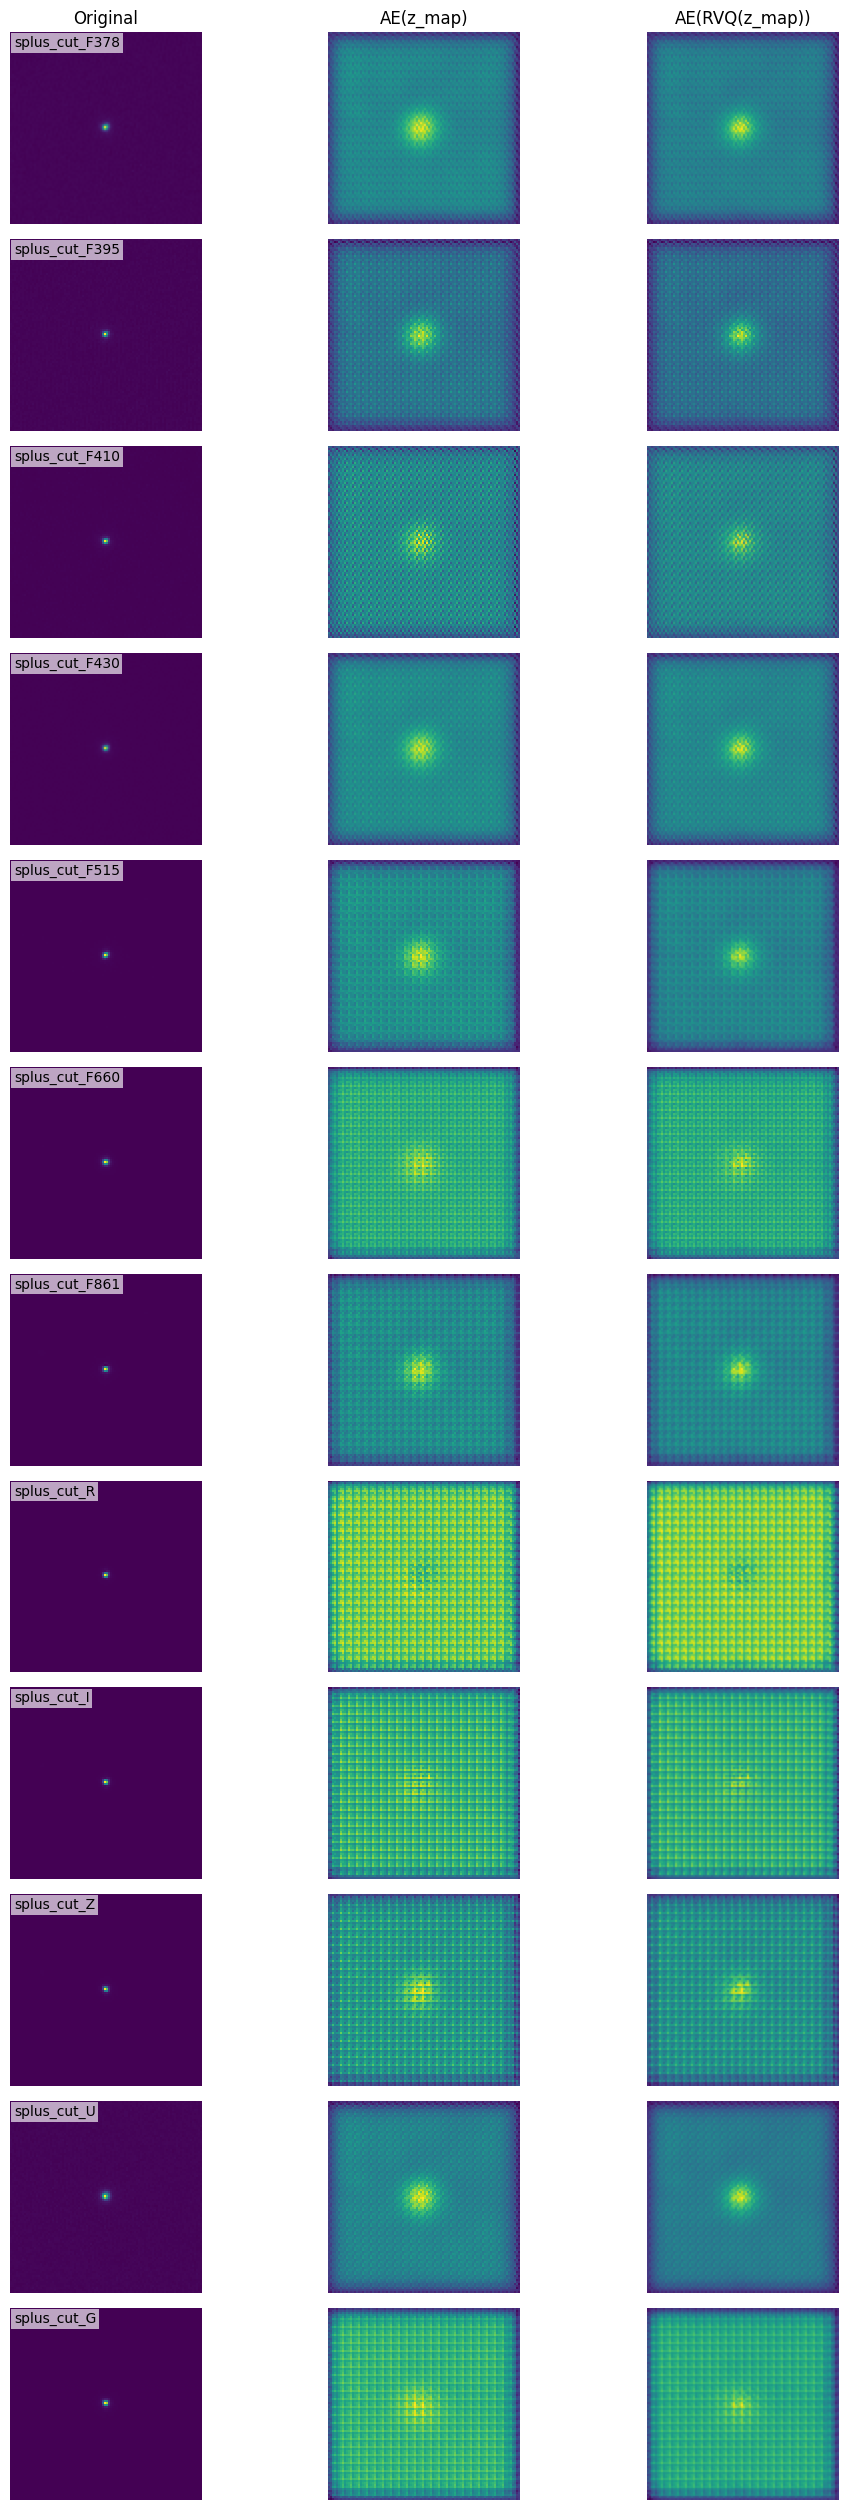

In [38]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def flat96_to_img(x, size=96):
    """
    x can be:
      - python list[float] length 9216
      - numpy array
      - polars list cell
    """
    arr = np.array(x, dtype=np.float32)
    if arr.ndim == 1:
        return arr.reshape(size, size)
    if arr.ndim == 2:
        return arr
    raise ValueError(f"Unexpected image ndim={arr.ndim}, shape={arr.shape}")

@torch.no_grad()
def run_one_3cols(idx, joined, columns, ae, srvq=None, device="cuda"):
    """
    Returns:
      x0_t       (1,12,96,96) original
      x_hat_ae   (1,12,96,96) AE decode(z_map)  <-- center column
      x_hat_rvq  (1,12,96,96) AE decode(z_q)    <-- right column (None if srvq=None)
    """
    device = torch.device(device)
    ae = ae.to(device).eval()
    if srvq is not None:
        srvq = srvq.to(device).eval()

    row = joined.row(idx, named=True)

    # Original cube
    imgs = [flat96_to_img(row[col], 96) for col in columns]  # list of (96,96)
    x0 = np.stack(imgs, axis=0)                              # (12,96,96)
    x0_t = torch.from_numpy(x0).unsqueeze(0).to(device)      # (1,12,96,96)

    # Latent back to spatial
    latent = row["latent"]                                   # (1152,)
    z = torch.tensor(np.asarray(latent, dtype=np.float32), device=device)
    z_map = z.view(1, 2, 24, 24)                             # (1,4,24,24)

    # Center: AE reconstruction directly from continuous latent
    x_hat_ae = ae.decode(z_map)                              # (1,12,96,96)

    # Right: AE reconstruction from RVQ-quantized latent (optional)
    x_hat_rvq = None
    with torch.no_grad():
        z_q = srvq(z_map, update_ema=False)["z_q"]
        x_hat_rvq = ae.decode(z_q)

    return x0_t, x_hat_ae, x_hat_rvq

def plot_12x3(x0_t, x_hat_ae, x_hat_rvq=None, columns=None, titles=None):
    """
    3 columns:
      col0 = original
      col1 = AE recon (no RVQ)
      col2 = AE recon (with RVQ) if provided
    """
    x0 = x0_t.squeeze(0).detach().cpu().numpy()
    xa = x_hat_ae.squeeze(0).detach().cpu().numpy()
    xr = None if x_hat_rvq is None else x_hat_rvq.squeeze(0).detach().cpu().numpy()

    n_bands = x0.shape[0]
    use_3 = xr is not None
    ncols = 3 if use_3 else 2

    if titles is None:
        titles = ["Original", "AE(z_map)"]
        if use_3:
            titles.append("AE(RVQ(z_map))")

    fig, axes = plt.subplots(n_bands, ncols, figsize=(3.6*ncols, 2.1*n_bands))
    if n_bands == 1:
        axes = np.expand_dims(axes, 0)
    if ncols == 1:
        axes = np.expand_dims(axes, 1)

    for i in range(n_bands):
        row_imgs = [x0[i], xa[i]] + ([xr[i]] if use_3 else [])
        for j in range(ncols):
            ax = axes[i, j]
            im = row_imgs[j]
            ax.imshow(im, origin="lower")
            ax.axis("off")

            if i == 0:
                ax.set_title(titles[j], fontsize=12)

            if columns is not None and j == 0:
                ax.text(
                    0.02, 0.98, str(columns[i]),
                    transform=ax.transAxes,
                    ha="left", va="top",
                    fontsize=10,
                    bbox=dict(facecolor="white", alpha=0.65, edgecolor="none", pad=2),
                )

    plt.tight_layout()
    plt.show()

# --- run
idx = 402
columns = ["splus_cut_F378","splus_cut_F395","splus_cut_F410","splus_cut_F430",
           "splus_cut_F515","splus_cut_F660","splus_cut_F861",
           "splus_cut_R","splus_cut_I","splus_cut_Z","splus_cut_U","splus_cut_G"]

x0_t, x_hat_ae, x_hat_rvq = run_one_3cols(idx, joined, columns, ae, srvq=srvq, device="cuda")
plot_12x3(x0_t, x_hat_ae, x_hat_rvq, columns=columns)

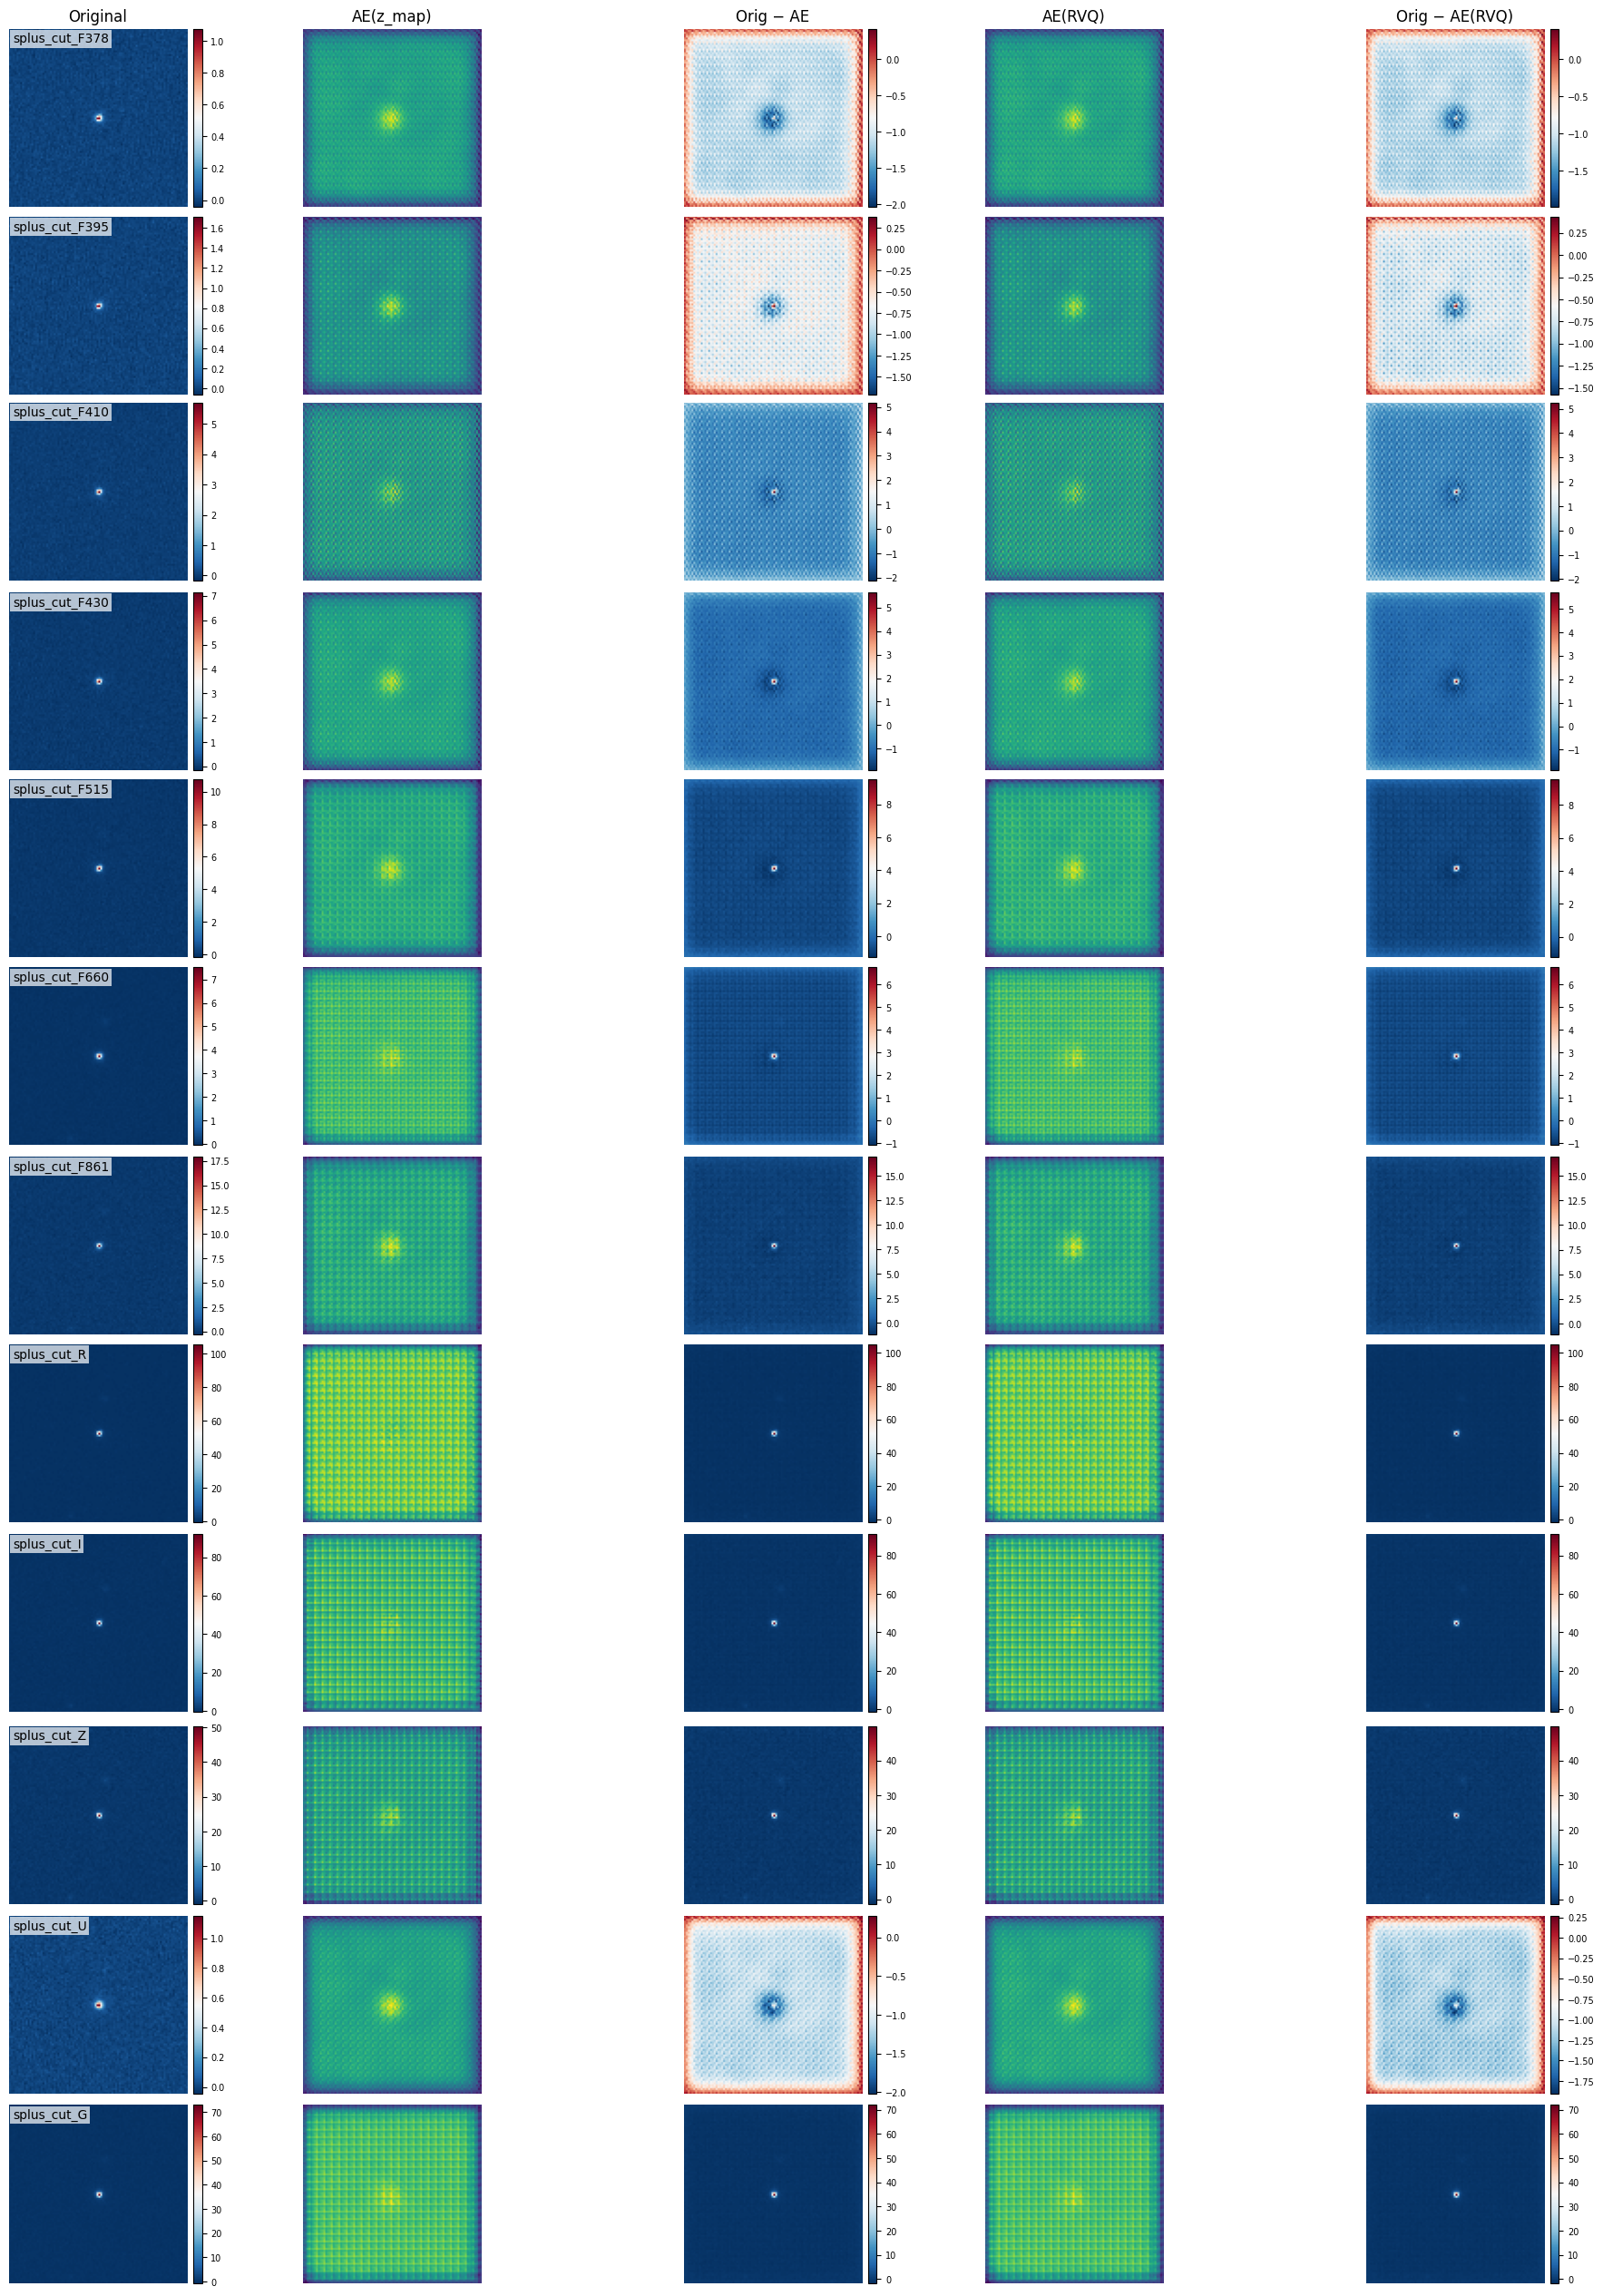

In [39]:
import numpy as np
import torch

@torch.no_grad()
def run_one_5cols(idx, joined, columns, ae, srvq=None, refiner=None, device="cuda"):
    device = torch.device(device)
    ae = ae.to(device).eval()
    if srvq is not None:
        srvq = srvq.to(device).eval()
    if refiner is not None:
        refiner = refiner.to(device).eval()

    row = joined.row(idx, named=True)

    # Original cube (1,12,96,96)
    imgs = [flat96_to_img(row[col], 96) for col in columns]
    x0 = np.stack(imgs, axis=0).astype(np.float32)
    x0_t = torch.from_numpy(x0).unsqueeze(0).to(device)

    # Latent -> spatial (1,2,24,24)
    latent = row["latent"]
    z = torch.tensor(np.asarray(latent, dtype=np.float32), device=device)
    z_map = z.view(1, 2, 24, 24)

    # AE recon
    x_hat_ae = ae.decode(z_map)

    # RVQ recon (optional)
    x_hat_rvq = None
    if srvq is not None:
        z_q = srvq(z_map, update_ema=False)["z_q"]
        if refiner is not None:
            z_q = refiner(z_q)
        x_hat_rvq = ae.decode(z_q)

    # Residuals
    resid_ae  = x0_t - x_hat_ae
    resid_rvq = None if x_hat_rvq is None else (x0_t - x_hat_rvq)

    return x0_t, x_hat_ae, x_hat_rvq, resid_ae, resid_rvq


import matplotlib.pyplot as plt

def plot_12x5(
    x0_t,
    x_hat_ae,
    x_hat_rvq,
    resid_ae,
    resid_rvq,
    columns=None,
    titles=None,
):
    x0 = x0_t.squeeze(0).detach().cpu().numpy()
    xa = x_hat_ae.squeeze(0).detach().cpu().numpy()
    xr = None if x_hat_rvq is None else x_hat_rvq.squeeze(0).detach().cpu().numpy()
    ra = resid_ae.squeeze(0).detach().cpu().numpy()
    rr = None if resid_rvq is None else resid_rvq.squeeze(0).detach().cpu().numpy()

    n_bands = x0.shape[0]
    use_rvq = xr is not None
    ncols = 5 if use_rvq else 3

    if titles is None:
        titles = ["Original", "AE(z_map)", "Orig − AE"]
        if use_rvq:
            titles += ["AE(RVQ)", "Orig − AE(RVQ)"]

    fig, axes = plt.subplots(
        n_bands,
        ncols,
        figsize=(3.8 * ncols, 2.1 * n_bands),
        constrained_layout=True,
    )

    if n_bands == 1:
        axes = np.expand_dims(axes, 0)

    for i in range(n_bands):
        row_imgs = [x0[i], xa[i], ra[i]]
        if use_rvq:
            row_imgs += [xr[i], rr[i]]

        for j in range(ncols):
            ax = axes[i, j]
            img = row_imgs[j]

            # Residual columns → symmetric color scale + colorbar
            if titles[j].startswith("Orig"):
                vmax = np.max(np.abs(img)) + 1e-12
                im = ax.imshow(
                    img,
                    origin="lower",
                    cmap="RdBu_r",
                )
                cbar = fig.colorbar(
                    im,
                    ax=ax,
                    fraction=0.046,
                    pad=0.02,
                )
                cbar.ax.tick_params(labelsize=7)
            else:
                ax.imshow(img, origin="lower")

            ax.axis("off")

            # Column titles
            if i == 0:
                ax.set_title(titles[j], fontsize=12)

            # Band labels
            if columns is not None and j == 0:
                ax.text(
                    0.02,
                    0.98,
                    str(columns[i]),
                    transform=ax.transAxes,
                    ha="left",
                    va="top",
                    fontsize=10,
                    bbox=dict(
                        facecolor="white",
                        alpha=0.7,
                        edgecolor="none",
                        pad=2,
                    ),
                )

    plt.show()
    
idx = 404
columns = ["splus_cut_F378","splus_cut_F395","splus_cut_F410","splus_cut_F430",
           "splus_cut_F515","splus_cut_F660","splus_cut_F861",
           "splus_cut_R","splus_cut_I","splus_cut_Z","splus_cut_U","splus_cut_G"]

x0_t, x_hat_ae, x_hat_rvq, resid_ae, resid_rvq = run_one_5cols(
    idx, joined, columns, ae, srvq=srvq, device="cuda"
)

plot_12x5(x0_t, x_hat_ae, x_hat_rvq, resid_ae, resid_rvq, columns=columns)